In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
data = pd.read_csv("data/IMDB Dataset.csv")
print (data.shape)
data.head(10)

(50000, 2)


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive

In [3]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
def remove_html(text):
    bs = BeautifulSoup(text, "html.parser")
    return ' ' + bs.get_text() + ' '

def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]',' ',text)
    return text

def convert_to_lowercase(text):
    return text.lower()

def clean_reviews(text):
    text = remove_html(text)
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text

In [6]:
data['review'] = data['review'].apply(lambda review: clean_reviews(review))

In [7]:
data['review_word_length'] = [len(review.split()) for review in data['review']]

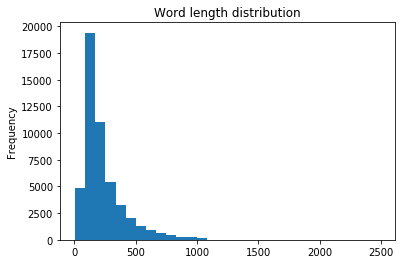

In [8]:
data['review_word_length'].plot(kind='hist', bins=30)
plt.title('Word length distribution')
plt.show()

## Splitting into Training and Test data

In [9]:
imdb_train = data[:40000]
imdb_test = data[40000:]

## Vocabulary

In [10]:
from collections import Counter

counter = Counter([words for reviews in imdb_train['review'] for words in reviews.split()])
df = pd.DataFrame()
df['key'] = counter.keys()
df['value'] = counter.values()
df.sort_values(by='value', ascending=False, inplace=True)
print(df.shape)
df.head()

(92279, 2)


key   value
2   the  533072
35  and  259694
47    a  258257
1    of  230754
58   to  213961

In [11]:
df[:10000].value.sum()/df.value.sum()

0.9477437089109378

In [12]:
top_10k_words = list(df[:10000].key.values)

## Input_Encoding

In [13]:
def get_encoded_input(review):
    words = review.split()
    if len(words) > 500:
        words = words[:500]
    encoding = []
    for word in words:
        try:
            index = top_10k_words.index(word)
        except:
            index = 10000
        encoding.append(index)
    while len(encoding) < 500:
        encoding.append(10001)
    return encoding

training_data = np.array([get_encoded_input(review) for review in imdb_train['review']])
testing_data = np.array([get_encoded_input(review) for review in imdb_test['review']])
print (training_data.shape, testing_data.shape)

(40000, 500) (10000, 500)


## Output Encoding

In [14]:
train_labels = [1 if sentiment=='positive' else 0 for sentiment in imdb_train['sentiment']]
test_labels = [1 if sentiment=='positive' else 0 for sentiment in imdb_test['sentiment']]
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
print (train_labels.shape, test_labels.shape)

(40000,) (10000,)


## RNN

In [77]:
import tensorflow
from tensorflow.keras.layers import Activation

input_data = tensorflow.keras.layers.Input(shape=(500))

data = tensorflow.keras.layers.Embedding(input_dim=10002, output_dim=32, input_length=500)(input_data)

data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.SimpleRNN(50))(data)

data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 500, 32)           320064    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               8300      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_30 (Activation)   (None, 1)                 0         
Total params: 328,465
Trainable params: 328,465
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))

Epoch 1/10
157/157 [==============================] - 40s 255ms/step - loss: 0.6135 - accuracy: 0.6421 - val_loss: 0.4859 - val_accuracy: 0.7753
Epoch 2/10
157/157 [==============================] - 43s 272ms/step - loss: 0.4299 - accuracy: 0.8159 - val_loss: 0.3808 - val_accuracy: 0.8456
Epoch 3/10
157/157 [==============================] - 57s 366ms/step - loss: 0.3181 - accuracy: 0.8716 - val_loss: 0.3756 - val_accuracy: 0.8381
Epoch 4/10
157/157 [==============================] - 56s 359ms/step - loss: 0.3109 - accuracy: 0.8718 - val_loss: 0.4366 - val_accuracy: 0.8352
Epoch 5/10
 11/157 [=>............................] - ETA: 48s - loss: 0.2274 - accuracy: 0.9173

KeyboardInterrupt: 

## LSTM

In [46]:
import tensorflow
from tensorflow.keras.layers import Activation

input_data = tensorflow.keras.layers.Input(shape=(500))

data = tensorflow.keras.layers.Embedding(input_dim=10002, output_dim=32, input_length=500)(input_data)

data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(50))(data)

data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 500, 32)           320064    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               33200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_15 (Activation)   (None, 1)                 0         
Total params: 353,365
Trainable params: 353,365
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(training_data, train_labels, epochs=10, batch_size=128, validation_data=(testing_data, test_labels))

Epoch 1/10
313/313 [==============================] - 140s 449ms/step - loss: 0.5606 - accuracy: 0.7155 - val_loss: 0.4979 - val_accuracy: 0.7681
Epoch 2/10
313/313 [==============================] - 142s 453ms/step - loss: 0.3372 - accuracy: 0.8625 - val_loss: 0.3041 - val_accuracy: 0.8714
Epoch 3/10
313/313 [==============================] - 142s 455ms/step - loss: 0.2705 - accuracy: 0.8979 - val_loss: 0.3145 - val_accuracy: 0.8777
Epoch 4/10
313/313 [==============================] - 155s 496ms/step - loss: 0.2132 - accuracy: 0.9235 - val_loss: 0.3785 - val_accuracy: 0.8484
Epoch 5/10
313/313 [==============================] - 153s 488ms/step - loss: 0.2182 - accuracy: 0.9210 - val_loss: 0.3360 - val_accuracy: 0.8748
Epoch 6/10
313/313 [==============================] - 159s 507ms/step - loss: 0.1941 - accuracy: 0.9291 - val_loss: 0.3379 - val_accuracy: 0.8725
Epoch 7/10
313/313 [==============================] - 181s 577ms/step - loss: 0.1592 - accuracy: 0.9448 - val_loss: 0.3238 -

## CNN

In [73]:
import tensorflow

input_data = tensorflow.keras.layers.Input(shape=(500))

data = tensorflow.keras.layers.Embedding(input_dim=10002, output_dim=32, input_length=500)(input_data)

data = tensorflow.keras.layers.Conv1D(100, kernel_size=3, activation='relu')(data)

data = tensorflow.keras.layers.Flatten()(data)

data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 500, 32)           320064    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 498, 100)          9700      
_________________________________________________________________
flatten_10 (Flatten)         (None, 49800)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 49801     
_________________________________________________________________
activation_29 (Activation)   (None, 1)                 0         
Total params: 379,565
Trainable params: 379,565
Non-trainable params: 0
_______________________________________________

In [74]:
model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))

Epoch 1/10
157/157 [==============================] - 19s 119ms/step - loss: 0.4682 - accuracy: 0.7482 - val_loss: 0.2724 - val_accuracy: 0.8893
Epoch 2/10
157/157 [==============================] - 20s 127ms/step - loss: 0.2289 - accuracy: 0.9110 - val_loss: 0.2605 - val_accuracy: 0.8955
Epoch 3/10
157/157 [==============================] - 22s 142ms/step - loss: 0.1742 - accuracy: 0.9342 - val_loss: 0.2828 - val_accuracy: 0.8931
Epoch 4/10
157/157 [==============================] - 23s 148ms/step - loss: 0.1460 - accuracy: 0.9464 - val_loss: 0.3166 - val_accuracy: 0.8862
Epoch 5/10
157/157 [==============================] - 22s 143ms/step - loss: 0.1174 - accuracy: 0.9583 - val_loss: 0.3416 - val_accuracy: 0.8909
Epoch 6/10
157/157 [==============================] - 22s 142ms/step - loss: 0.0993 - accuracy: 0.9652 - val_loss: 0.3775 - val_accuracy: 0.8877
Epoch 7/10
157/157 [==============================] - 23s 147ms/step - loss: 0.0734 - accuracy: 0.9762 - val_loss: 0.4453 - val_ac